<a href="https://colab.research.google.com/github/CMPSC-310-AI-Spring2023/activity08_classification-jjumadinova/blob/main/CMPSC_310_Activity8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Activity 8: Classification Example**

Ref: Chapter 3 in "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by A. Géron

Ref: https://github.com/ageron/handson-ml3

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np

**Dataset**

MNIST dataset: 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This snippet of the code fetches the MNIST dataset from OpenML.org

The sklearn.datasets package contains mostly three types of functions: fetch_*  functions such as `fetch_openml()` to download real-life datasets, load_* functions to load small toy datasets bundled with Scikit-Learn, and make_* functions to generate fake datasets, useful for tests. Generated datasets are usually returned as an `(X, y)` tuple containing the input data and the targets, both as NumPy arrays. Other datasets are returned as `sklearn.utils.Bunch` objects, which are dictionaries whose entries can also be accessed as attributes.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


The `fetch_openml()` function is a bit unusual since by default it returns the inputs as a Pandas DataFrame and the labels as a Pandas Series (unless the dataset is sparse). But the MNIST dataset contains images, and DataFrames aren't ideal for that, so it's preferable to set `as_frame=False` to get the data as NumPy arrays instead. We can look at these arrays:

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

In [4]:
y.shape

(70000,)

In [5]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We can look at one digit from the dataset. We will grab an instance's feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib's `imshow()` function. We use `cmap="binary"` to get a grayscale color map where 0 is white and 255 is black.

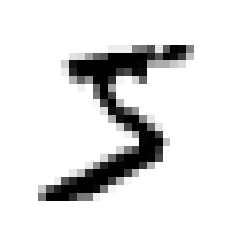

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

This looks like a 5, and indeed that's what the label tells us:

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

**Classification Task**

The MNIST dataset returned by `fetch_openml()` is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images). The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits).

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Binary Classifier**

We will simplify the problem for now and only try to identify one digit—for example, the number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5. First, create the target vectors for this classification task:

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Then, select a classifier and train it. We will start with a stochastic gradient descent (SGD, or stochastic GD) classifier, using Scikit-Learn’s `SGDClassifier` class. This classifier is capable of handling very large datasets efficiently.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Use it to detect images of the number 5:

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# **Performance Measures**

A good way to evaluate a model is to use cross-validation. We will use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using k-fold cross-validation with three folds. k-fold cross-validation means we are splitting the training set into k folds (in this case, three), then training the model k times, holding out a different fold each time for evaluation.


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

We got 95% accuracy (ratio of correct predictions) on all cross-validation folds. Amazing!

Let's try a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class.

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Dummy classifier has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it's best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" here means "out-of-sample": the model makes predictions on data that it never saw during training).

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`):

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives, also called type II errors), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric, such as precision or recall. Scikit-Learn provides several functions to compute classifier metrics, including precision and recall.

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

To compute the F1 score, simply call the f1_score() function:

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall *trade-off*.

To understand this trade-off, let's look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier's `predict()` method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the same result as the predict() method (i.e., True). Let's raise the threshold:

In [23]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions. With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value. Let's show the threshold of 3,000 we selected. We can see that at this threshold value, precision is near 90% and recall is around 50%. 

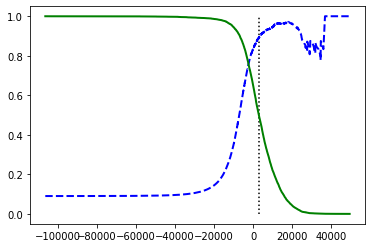

In [25]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
[...]  # beautify the figure: add grid, legend, axis, labels, and circles
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall. You can see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

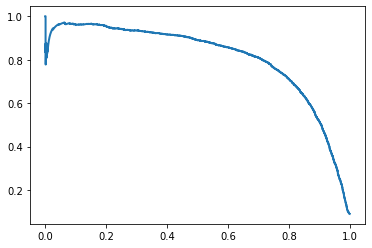

In [26]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
[...]  # beautify the figure: add labels, grid, legend, arrow, and text
plt.show()

Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the NumPy array’s argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [27]:
idx_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier's `predict()` method, you can run this code:

In [28]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let's check these predictions' precision and recall:

In [29]:
precision_score(y_train_5, y_train_pred_90)
0.9000345901072293
recall_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_90_precision

0.4799852425751706

## **Try a different algorithm**

Let's now create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier:

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The `precision_recall_curve()` function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance. But the RandomForestClassifier class does not have a `decision_function()` method, due to the way it works. Luckily, it has a `predict_proba()` method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine. We can call the `cross_val_predict()` function to train the `RandomForestClassifier` using cross-validation and make it predict class probabilities for every image as follows and then we look at the class probabilities for the first two images in the training set:

In [31]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the probabilities in each row add up to 100%.